<a href="https://colab.research.google.com/github/Bicchie/Skin-Lesions-Classification/blob/main/6_ResNet.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

#Skin Lesions Classifications using pretrained network ResNet

## Initialization

In [ ]:
from google.colab import drive
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras import optimizers
from keras import layers
from keras import models
import os
import math
import shutil
import matplotlib.pyplot as plt
from sklearn import metrics
from sklearn.metrics import ConfusionMatrixDisplay
import numpy as np

In [ ]:
drive.mount('/content/gdrive', force_remount=True)

Mounted at /content/gdrive


In [ ]:
IMAGE_HEIGHT = 224
IMAGE_WIDTH = 224
TRAIN_DIR = '/content/gdrive/MyDrive/SkinCancer/OriginalDataset/train'
VAL_DIR = '/content/gdrive/MyDrive/SkinCancer/OriginalDataset/val'
TEST_DIR = '/content/gdrive/MyDrive/SkinCancer/OriginalDataset/test'
MODELS_PATH = '/content/gdrive/MyDrive/SkinCancer/Models'

LOCAL_MODELS_FOLDER = "/content/models"
if not os.path.exists(LOCAL_MODELS_FOLDER):
  os.makedirs(LOCAL_MODELS_FOLDER)
GLOBAL_MODELS_FOLDER = "/content/gdrive/MyDrive/SkinCancer/Models/ResNet"
if not os.path.exists(GLOBAL_MODELS_FOLDER):
  os.makedirs(GLOBAL_MODELS_FOLDER)

CLASSES = ['Actinic', 'BCC', 'Dermatofibroma', 'Keratosis', 'Melanoma', 'Nevu', 'Vascular']
BATCH_SIZE = 32
RANDOM_SEED = 42
EPOCHS=50
DROPOUT = 0.3

###Dataset Loading

Note that since 450x600 is too large, It is used the interpolation tool in Keras to resize the images in 224x224, also to fit the input of most pretrained networks.

In [ ]:
training_images = tf.keras.preprocessing.image_dataset_from_directory(
    TRAIN_DIR,
    labels='inferred',
    batch_size=BATCH_SIZE,
    color_mode='rgb',
    image_size=(IMAGE_HEIGHT,IMAGE_WIDTH),
    interpolation='bilinear',
    shuffle=True,
    seed=RANDOM_SEED
)

val_images = tf.keras.preprocessing.image_dataset_from_directory(
    VAL_DIR,
    labels='inferred',
    batch_size=BATCH_SIZE,
    color_mode='rgb',
    image_size=(IMAGE_HEIGHT,IMAGE_WIDTH),
    interpolation='bilinear',
    shuffle=True,
    seed=RANDOM_SEED
)

test_images = tf.keras.preprocessing.image_dataset_from_directory(
    TEST_DIR,
    labels='inferred',
    batch_size=BATCH_SIZE,
    color_mode='rgb',
    image_size=(IMAGE_HEIGHT,IMAGE_WIDTH),
    interpolation='bilinear',
    shuffle=False,
    seed=RANDOM_SEED
)

Found 7014 files belonging to 7 classes.
Found 1500 files belonging to 7 classes.
Found 1511 files belonging to 7 classes.


In [ ]:
print(training_images)

<BatchDataset element_spec=(TensorSpec(shape=(None, 224, 224, 3), dtype=tf.float32, name=None), TensorSpec(shape=(None,), dtype=tf.int32, name=None))>


## Utility

In [ ]:
def compile_model(model, metrics='accuracy', loss='sparse_categorical_crossentropy', optimizer='adam', learning_rate = 0.001):
  '''
    compile_model is used to compile the current model
    :param model: model to compile
    :param optimizer: optimizer to be used
    :param learning_rate: learning rate parameter for the optimizer
  '''
  if optimizer == 'adam':
    optimizer=optimizers.Adam(learning_rate=learning_rate)
  elif optimizer == 'rmsprop':
    optimizer = optimizers.RMSprop(learning_rate=learning_rate)
  else:
    return

  model.compile(loss=loss,
    optimizer=optimizer,
    metrics=[metrics])

  return model

def run_model (model, model_name, train_ds, val_ds, epochs=50, patience=3, monitor='val_loss', class_weight=None):
  '''
  run_model is used to run the current mode
  :param model: model to run
  :param model_name: name given to save the model
  :param epochs: how many epochs to do
  :param patience: patience value for Early Stopping
  :param monitor: what to monitor for Early Stopping and Model Checkpoint
  '''
  # local save path for the models
  save_path = LOCAL_MODELS_FOLDER + '/' + model_name + ".h5"

  callbacks_list = [
                  keras.callbacks.EarlyStopping(monitor=monitor, patience=patience), #we implement EarlyStopping to prevent overfitting
                  keras.callbacks.ModelCheckpoint(
                      filepath = save_path,
                      monitor=monitor,
                      verbose=1,
                      save_best_only=True)
                  ]
           
  history = model.fit(train_ds,
                    epochs=epochs,
                    validation_data=val_ds,
                    callbacks=callbacks_list,
                    class_weight=class_weight
                    )
  # save on Drive only the best model
  shutil.copy(save_path, GLOBAL_MODELS_FOLDER + '/' + model_name + '.h5')
  return tf.keras.models.load_model(save_path), history


def show_training_and_validation_performance(history):
  '''
  show_training_and_validation_performance is used to plot the performances during the training phase
  :param history: object in which are recorded all the events
  '''
  acc = history.history['accuracy']
  val_acc = history.history['val_accuracy']
  loss = history.history['loss']
  val_loss = history.history['val_loss']

  epochs = range(len(acc))

  plt.plot(epochs, acc, 'bo', label='Training accuracy')
  plt.plot(epochs, val_acc, 'b', label='Validation accuracy')
  plt.title('Training and validation accuracy')
  plt.legend()

  plt.figure()

  plt.plot(epochs, loss, 'bo', label='Training loss')
  plt.plot(epochs, val_loss, 'b', label='Validation loss')
  plt.title('Training and validation loss')
  plt.legend()

  plt.show()


def evaluate_model(model, test_ds):
  test_loss, test_accuracy = model.evaluate(test_ds)
  print("Loss on test set: " +str(test_loss))
  print("Accuracy on test set: " +str(test_accuracy))
  test_labels = np.concatenate([label for image, label in test_ds], axis=0) # retrieve the labels of the test set
  test_predictions = model.predict(test_ds)  # probabilities for all classes
  test_predictions = np.argmax(test_predictions, axis=-1)  # index of the classes with largest probability
  print(metrics.classification_report(test_labels, test_predictions, target_names=CLASSES, digits=4))

def plot_confusionmatrix(model, test_ds):
  test_labels = np.concatenate([label for image, label in test_ds], axis=0) # retrieve the labels of the test set
  test_predictions = model.predict(test_ds, verbose=1)  # probabilities for all classes
  test_predictions = np.argmax(test_predictions, axis=-1)  # index of the classes with largest probability
  # plot confusion matrix
  fig, ax = plt.subplots(figsize=(10, 10))
  ConfusionMatrixDisplay.from_predictions(test_labels, test_predictions, xticks_rotation='vertical', ax=ax, display_labels=CLASSES)


def create_class_weight(labels_dict,mu=0.7):
    total = np.sum(list(labels_dict.values()))
    keys = labels_dict.keys()
    class_weight = dict()
    
    for key in keys:
        score = math.log(mu*total/float(labels_dict[key]))
        class_weight[key] = score if score > 0.5 else 0.5
    
    return class_weight

# actually compute the CLASS WEIGHTS
labels_dict = {0:327, 1:514, 2:115, 3:1099, 4:1113, 5:6705, 6:142}

class_weight = create_class_weight(labels_dict)

## Feature Extraction

Let's use the ResNet as Feature Extractor.

In [ ]:
resnet = keras.applications.resnet.ResNet50(
    weights="imagenet",
    include_top=False,
    input_shape=(224,224,3)
)

resnet.trainable = False
resnet.summary()

94781440/94765736 [==============================] - 1s 0us/step
Model: "resnet50"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_1 (InputLayer)           [(None, 224, 224, 3  0           []                               
                                )]                                                                
                                                                                                  
 conv1_pad (ZeroPadding2D)      (None, 230, 230, 3)  0           ['input_1[0][0]']                
                                                                                                  
 conv1_conv (Conv2D)            (None, 112, 112, 64  9472        ['conv1_pad[0][0]']              
                                )                                                                 
                          

###Dense

In [ ]:
inputs = keras.Input(shape=(IMAGE_HEIGHT,IMAGE_WIDTH,3))
x = keras.applications.resnet50.preprocess_input(inputs)
x = resnet(x)

x = layers.GlobalAveragePooling2D(name='gap')(x)
x = layers.Dense(512,activation='relu', name='classifier_hidden')(x)
output = layers.Dense(len(CLASSES), activation='softmax')(x)
model = tf.keras.models.Model(inputs=inputs, outputs=output, name="ResNet")

model = compile_model(model, loss="sparse_categorical_crossentropy")
model.summary()

Model: "ResNet"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_2 (InputLayer)        [(None, 224, 224, 3)]     0         
                                                                 
 tf.__operators__.getitem (S  (None, 224, 224, 3)      0         
 licingOpLambda)                                                 
                                                                 
 tf.nn.bias_add (TFOpLambda)  (None, 224, 224, 3)      0         
                                                                 
 resnet50 (Functional)       (None, 7, 7, 2048)        23587712  
                                                                 
 gap (GlobalAveragePooling2D  (None, 2048)             0         
 )                                                               
                                                                 
 classifier_hidden (Dense)   (None, 512)               10490

In [ ]:
model, history = run_model(model, "Dense", training_images, val_images, EPOCHS, patience=5, monitor='val_loss', class_weight=class_weight)

Epoch 1/50
220/220 [==============================] - ETA: 0s - loss: 1.4066 - accuracy: 0.6496
Epoch 1: val_loss improved from inf to 0.71210, saving model to /content/models/Dense.h5
220/220 [==============================] - 799s 3s/step - loss: 1.4066 - accuracy: 0.6496 - val_loss: 0.7121 - val_accuracy: 0.7320
Epoch 2/50
219/220 [============================>.] - ETA: 0s - loss: 0.9204 - accuracy: 0.7383
Epoch 2: val_loss did not improve from 0.71210
220/220 [==============================] - 28s 123ms/step - loss: 0.9208 - accuracy: 0.7382 - val_loss: 0.8323 - val_accuracy: 0.6800
Epoch 3/50
219/220 [============================>.] - ETA: 0s - loss: 0.7704 - accuracy: 0.7697
Epoch 3: val_loss improved from 0.71210 to 0.68629, saving model to /content/models/Dense.h5
220/220 [==============================] - 30s 133ms/step - loss: 0.7703 - accuracy: 0.7697 - val_loss: 0.6863 - val_accuracy: 0.7453
Epoch 4/50
219/220 [============================>.] - ETA: 0s - loss: 0.6718 - accu

In [ ]:
evaluate_model(model, test_images)

48/48 [==============================] - 144s 3s/step - loss: 0.6512 - accuracy: 0.7915
Loss on test set: 0.6511757969856262
Accuracy on test set: 0.7915287613868713
                precision    recall  f1-score   support

       Actinic     0.4643    0.5200    0.4906        50
           BCC     0.4957    0.7250    0.5888        80
Dermatofibroma     0.5882    0.5556    0.5714        18
     Keratosis     0.6519    0.5301    0.5847       166
      Melanoma     0.5444    0.5476    0.5460       168
          Nevu     0.9077    0.8987    0.9032      1007
      Vascular     0.8500    0.7727    0.8095        22

      accuracy                         0.7915      1511
     macro avg     0.6432    0.6500    0.6420      1511
  weighted avg     0.7981    0.7915    0.7929      1511



48/48 [==============================] - 5s 109ms/step


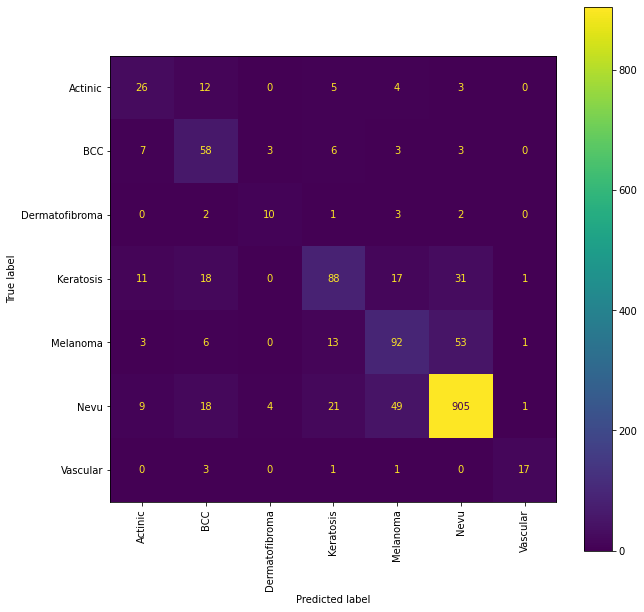

In [ ]:
plot_confusionmatrix(model, test_images)

### Dense Layer and Dropout

In [ ]:
inputs = keras.Input(shape=(IMAGE_HEIGHT,IMAGE_WIDTH,3))
x = keras.applications.resnet50.preprocess_input(inputs)
x = resnet(x)

x = layers.GlobalAveragePooling2D(name='gap')(x)
x = layers.Flatten(name='flatten')(x)
x = layers.Dense(512,activation='relu', name='classifier_hidden')(x)
x = layers.Dropout(DROPOUT)(x)
output = layers.Dense(len(CLASSES), activation='softmax')(x)

model = tf.keras.models.Model(inputs=inputs, outputs=output, name="ResNet")

model = compile_model(model, loss="sparse_categorical_crossentropy")
model.summary()

Model: "ResNet"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_3 (InputLayer)        [(None, 224, 224, 3)]     0         
                                                                 
 tf.__operators__.getitem_1   (None, 224, 224, 3)      0         
 (SlicingOpLambda)                                               
                                                                 
 tf.nn.bias_add_1 (TFOpLambd  (None, 224, 224, 3)      0         
 a)                                                              
                                                                 
 resnet50 (Functional)       (None, 7, 7, 2048)        23587712  
                                                                 
 gap (GlobalAveragePooling2D  (None, 2048)             0         
 )                                                               
                                                            

In [ ]:
model, history = run_model(model, "DenseDropout", training_images, val_images, EPOCHS, patience=5, monitor='val_loss', class_weight=class_weight)

Epoch 1/50
219/220 [============================>.] - ETA: 0s - loss: 1.5614 - accuracy: 0.6314
Epoch 1: val_loss improved from inf to 0.78004, saving model to /content/models/DenseDropout.h5
220/220 [==============================] - 32s 132ms/step - loss: 1.5604 - accuracy: 0.6317 - val_loss: 0.7800 - val_accuracy: 0.7280
Epoch 2/50
219/220 [============================>.] - ETA: 0s - loss: 1.0744 - accuracy: 0.7008
Epoch 2: val_loss did not improve from 0.78004
220/220 [==============================] - 29s 129ms/step - loss: 1.0742 - accuracy: 0.7009 - val_loss: 0.7951 - val_accuracy: 0.7107
Epoch 3/50
219/220 [============================>.] - ETA: 0s - loss: 0.9457 - accuracy: 0.7280
Epoch 3: val_loss improved from 0.78004 to 0.66724, saving model to /content/models/DenseDropout.h5
220/220 [==============================] - 29s 127ms/step - loss: 0.9451 - accuracy: 0.7281 - val_loss: 0.6672 - val_accuracy: 0.7493
Epoch 4/50
219/220 [============================>.] - ETA: 0s - los

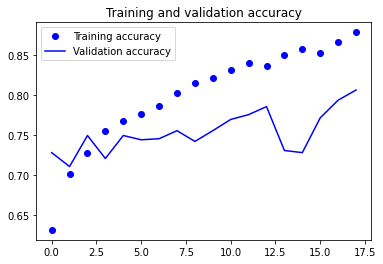

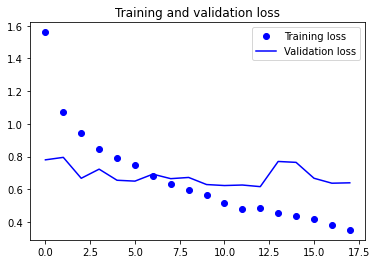

In [ ]:
show_training_and_validation_performance(history)

In [ ]:
evaluate_model(model, test_images)

48/48 [==============================] - 6s 104ms/step - loss: 0.6560 - accuracy: 0.7717
Loss on test set: 0.6559931635856628
Accuracy on test set: 0.771674394607544
                precision    recall  f1-score   support

       Actinic     0.5897    0.4600    0.5169        50
           BCC     0.5962    0.3875    0.4697        80
Dermatofibroma     0.5000    0.3333    0.4000        18
     Keratosis     0.5699    0.6627    0.6128       166
      Melanoma     0.4434    0.5833    0.5039       168
          Nevu     0.9071    0.8729    0.8897      1007
      Vascular     0.7600    0.8636    0.8085        22

      accuracy                         0.7717      1511
     macro avg     0.6238    0.5948    0.6002      1511
  weighted avg     0.7846    0.7717    0.7748      1511



48/48 [==============================] - 5s 106ms/step


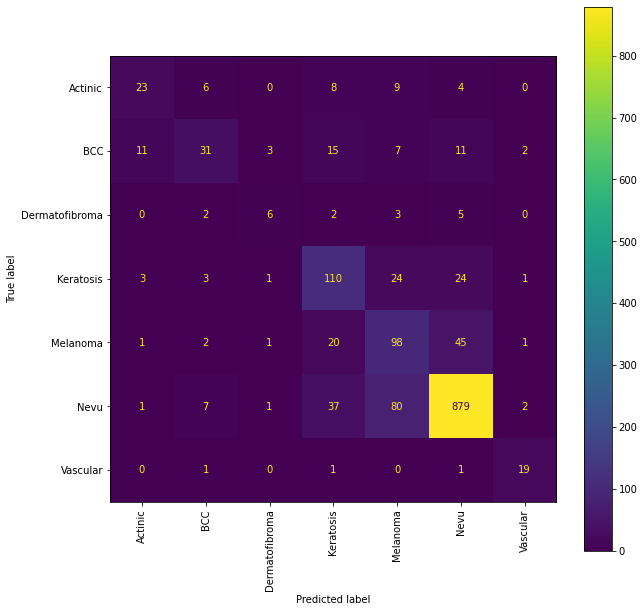

In [ ]:
plot_confusionmatrix(model, test_images)

## Fine Tuning

In [ ]:
model = models.load_model('/content/gdrive/MyDrive/SkinCancer/Models/ResNet/Dense.h5')

### Last Mini Block

In [ ]:
trainable = False

for layer in model.get_layer("resnet50").layers:
    if 'conv5_block3_3_conv' in layer.name:
        trainable = True
    is_bn = layer.name.endswith('bn')  # keep BatchNorm freezed, good practice for finetuned models
    if not is_bn:
      layer.trainable = trainable

model = compile_model(model, loss="sparse_categorical_crossentropy", learning_rate=0.0001)
model.summary()

Model: "ResNet"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_2 (InputLayer)        [(None, 224, 224, 3)]     0         
                                                                 
 tf.__operators__.getitem (S  (None, 224, 224, 3)      0         
 licingOpLambda)                                                 
                                                                 
 tf.nn.bias_add (TFOpLambda)  (None, 224, 224, 3)      0         
                                                                 
 resnet50 (Functional)       (None, 7, 7, 2048)        23587712  
                                                                 
 gap (GlobalAveragePooling2D  (None, 2048)             0         
 )                                                               
                                                                 
 classifier_hidden (Dense)   (None, 512)               10490

In [ ]:
model, history = run_model(model, "FT_LastBlock", training_images, val_images, EPOCHS, patience=5, monitor='val_loss', class_weight=class_weight)

Epoch 1/50
220/220 [==============================] - ETA: 0s - loss: 0.3379 - accuracy: 0.8831
Epoch 1: val_loss improved from inf to 0.69368, saving model to /content/models/FT_LastBlock.h5
220/220 [==============================] - 34s 131ms/step - loss: 0.3379 - accuracy: 0.8831 - val_loss: 0.6937 - val_accuracy: 0.7573
Epoch 2/50
219/220 [============================>.] - ETA: 0s - loss: 0.2211 - accuracy: 0.9254
Epoch 2: val_loss improved from 0.69368 to 0.62374, saving model to /content/models/FT_LastBlock.h5
220/220 [==============================] - 30s 134ms/step - loss: 0.2210 - accuracy: 0.9254 - val_loss: 0.6237 - val_accuracy: 0.7953
Epoch 3/50
219/220 [============================>.] - ETA: 0s - loss: 0.1739 - accuracy: 0.9409
Epoch 3: val_loss did not improve from 0.62374
220/220 [==============================] - 28s 126ms/step - loss: 0.1738 - accuracy: 0.9410 - val_loss: 0.6512 - val_accuracy: 0.7987
Epoch 4/50
219/220 [============================>.] - ETA: 0s - los

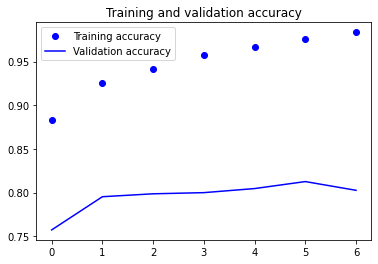

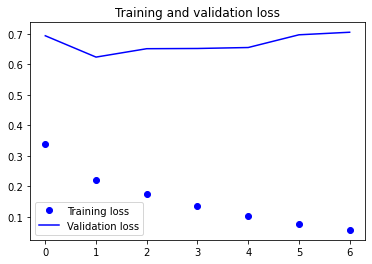

In [ ]:
show_training_and_validation_performance(history)

In [ ]:
evaluate_model(model, test_images)

48/48 [==============================] - 6s 103ms/step - loss: 0.6790 - accuracy: 0.7836
Loss on test set: 0.6789987087249756
Accuracy on test set: 0.7835870385169983
                precision    recall  f1-score   support

       Actinic     0.5106    0.4800    0.4948        50
           BCC     0.4836    0.7375    0.5842        80
Dermatofibroma     0.4167    0.5556    0.4762        18
     Keratosis     0.6051    0.5723    0.5882       166
      Melanoma     0.5260    0.5417    0.5337       168
          Nevu     0.9193    0.8818    0.9002      1007
      Vascular     0.7727    0.7727    0.7727        22

      accuracy                         0.7836      1511
     macro avg     0.6049    0.6488    0.6214      1511
  weighted avg     0.7963    0.7836    0.7881      1511



48/48 [==============================] - 5s 107ms/step


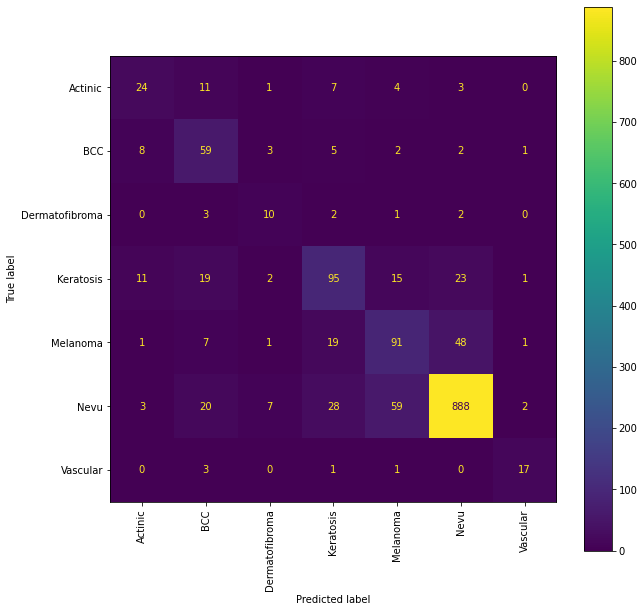

In [ ]:
plot_confusionmatrix(model, test_images)

### Last Block

In [ ]:
trainable = False

for layer in model.get_layer("resnet50").layers:
    if 'conv5_block3' in layer.name:
        trainable = True
    is_bn = layer.name.endswith('bn')  # keep BatchNorm freezed, good practice for finetuned models
    if not is_bn:
      layer.trainable = trainable

model = compile_model(model, loss="sparse_categorical_crossentropy", learning_rate=0.0001)
model.summary()

Model: "ResNet"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_2 (InputLayer)        [(None, 224, 224, 3)]     0         
                                                                 
 tf.__operators__.getitem (S  (None, 224, 224, 3)      0         
 licingOpLambda)                                                 
                                                                 
 tf.nn.bias_add (TFOpLambda)  (None, 224, 224, 3)      0         
                                                                 
 resnet50 (Functional)       (None, 7, 7, 2048)        23587712  
                                                                 
 gap (GlobalAveragePooling2D  (None, 2048)             0         
 )                                                               
                                                                 
 classifier_hidden (Dense)   (None, 512)               10490

In [ ]:
model, history = run_model(model, "FT_LastWhole", training_images, val_images, EPOCHS, patience=5, monitor='val_loss', class_weight=class_weight)

Epoch 1/50
220/220 [==============================] - ETA: 0s - loss: 0.3109 - accuracy: 0.8999
Epoch 1: val_loss improved from inf to 0.59578, saving model to /content/models/FT_LastWhole.h5
220/220 [==============================] - 36s 143ms/step - loss: 0.3109 - accuracy: 0.8999 - val_loss: 0.5958 - val_accuracy: 0.7887
Epoch 2/50
219/220 [============================>.] - ETA: 0s - loss: 0.1880 - accuracy: 0.9368
Epoch 2: val_loss improved from 0.59578 to 0.58189, saving model to /content/models/FT_LastWhole.h5
220/220 [==============================] - 31s 136ms/step - loss: 0.1884 - accuracy: 0.9366 - val_loss: 0.5819 - val_accuracy: 0.7933
Epoch 3/50
219/220 [============================>.] - ETA: 0s - loss: 0.1296 - accuracy: 0.9569
Epoch 3: val_loss did not improve from 0.58189
220/220 [==============================] - 30s 135ms/step - loss: 0.1295 - accuracy: 0.9569 - val_loss: 0.6367 - val_accuracy: 0.8087
Epoch 4/50
219/220 [============================>.] - ETA: 0s - los

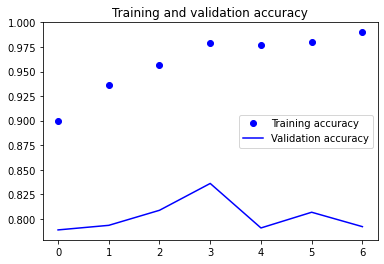

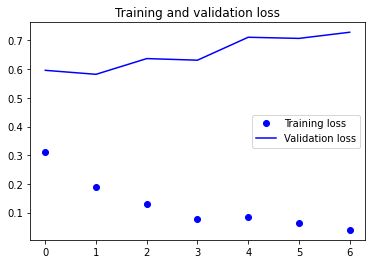

In [ ]:
show_training_and_validation_performance(history)

In [ ]:
evaluate_model(model, test_images)

48/48 [==============================] - 6s 106ms/step - loss: 0.6219 - accuracy: 0.7836
Loss on test set: 0.6218715906143188
Accuracy on test set: 0.7835870385169983
                precision    recall  f1-score   support

       Actinic     0.5250    0.4200    0.4667        50
           BCC     0.5243    0.6750    0.5902        80
Dermatofibroma     0.5000    0.5556    0.5263        18
     Keratosis     0.6513    0.5964    0.6226       166
      Melanoma     0.4864    0.6369    0.5515       168
          Nevu     0.9144    0.8699    0.8916      1007
      Vascular     0.9444    0.7727    0.8500        22

      accuracy                         0.7836      1511
     macro avg     0.6494    0.6466    0.6427      1511
  weighted avg     0.7999    0.7836    0.7893      1511



48/48 [==============================] - 5s 108ms/step


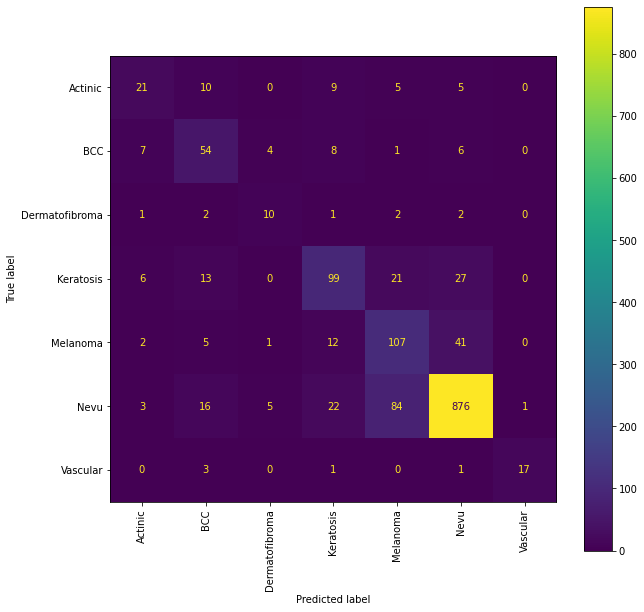

In [ ]:
plot_confusionmatrix(model, test_images)

### Last Conv Block

In [ ]:
trainable = False

for layer in model.get_layer("resnet50").layers:
    if 'conv5' in layer.name:
        trainable = True
    is_bn = layer.name.endswith('bn')  # keep BatchNorm freezed, good practice for finetuned models
    if not is_bn:
      layer.trainable = trainable

model = compile_model(model, loss="sparse_categorical_crossentropy", learning_rate=0.0001)
model.summary()

Model: "ResNet"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_2 (InputLayer)        [(None, 224, 224, 3)]     0         
                                                                 
 tf.__operators__.getitem (S  (None, 224, 224, 3)      0         
 licingOpLambda)                                                 
                                                                 
 tf.nn.bias_add (TFOpLambda)  (None, 224, 224, 3)      0         
                                                                 
 resnet50 (Functional)       (None, 7, 7, 2048)        23587712  
                                                                 
 gap (GlobalAveragePooling2D  (None, 2048)             0         
 )                                                               
                                                                 
 classifier_hidden (Dense)   (None, 512)               10490

In [ ]:
model, history = run_model(model, "FT_LastConv", training_images, val_images, EPOCHS, patience=5, monitor='val_loss', class_weight=class_weight)

Epoch 1/50
220/220 [==============================] - ETA: 0s - loss: 0.6458 - accuracy: 0.8020
Epoch 1: val_loss improved from inf to 0.62385, saving model to /content/models/FT_LastConv.h5
220/220 [==============================] - 41s 167ms/step - loss: 0.6458 - accuracy: 0.8020 - val_loss: 0.6239 - val_accuracy: 0.7633
Epoch 2/50
219/220 [============================>.] - ETA: 0s - loss: 0.3739 - accuracy: 0.8789
Epoch 2: val_loss improved from 0.62385 to 0.60666, saving model to /content/models/FT_LastConv.h5
220/220 [==============================] - 37s 163ms/step - loss: 0.3736 - accuracy: 0.8790 - val_loss: 0.6067 - val_accuracy: 0.7940
Epoch 3/50
219/220 [============================>.] - ETA: 0s - loss: 0.2721 - accuracy: 0.9060
Epoch 3: val_loss improved from 0.60666 to 0.52438, saving model to /content/models/FT_LastConv.h5
220/220 [==============================] - 36s 162ms/step - loss: 0.2719 - accuracy: 0.9060 - val_loss: 0.5244 - val_accuracy: 0.8220
Epoch 4/50
219/22

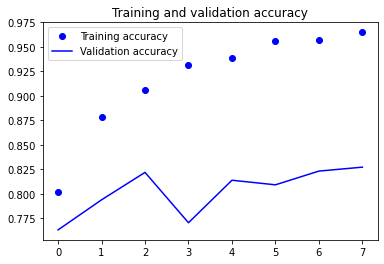

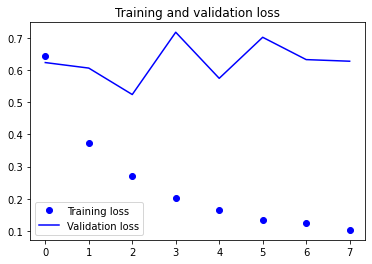

In [ ]:
show_training_and_validation_performance(history)

In [ ]:
evaluate_model(model, test_images)

48/48 [==============================] - 6s 104ms/step - loss: 0.5840 - accuracy: 0.8101
Loss on test set: 0.5840002298355103
Accuracy on test set: 0.8100595474243164
                precision    recall  f1-score   support

       Actinic     0.4231    0.4400    0.4314        50
           BCC     0.6667    0.6000    0.6316        80
Dermatofibroma     0.4444    0.4444    0.4444        18
     Keratosis     0.6913    0.6205    0.6540       166
      Melanoma     0.6400    0.4762    0.5461       168
          Nevu     0.8814    0.9374    0.9086      1007
      Vascular     0.7917    0.8636    0.8261        22

      accuracy                         0.8101      1511
     macro avg     0.6484    0.6260    0.6346      1511
  weighted avg     0.8006    0.8101    0.8031      1511



48/48 [==============================] - 5s 107ms/step


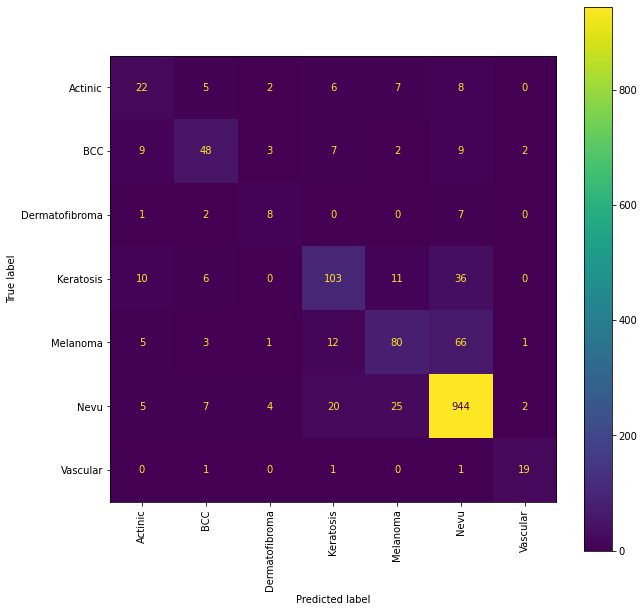

In [ ]:
plot_confusionmatrix(model, test_images)